In [1]:
from fastai.vision.all import *
import fastai
import timm
import pandas as pd

In [2]:
import torch
torch.cuda.set_device(2)

In [3]:
df = pd.read_csv('../dataset.csv')

In [4]:
df = df.drop(df[df.masa<0].index)

In [5]:
dftrain = df[(df.split=='train') | (df.split=='valid')]
dftest = df[(df.split=='test')]

In [6]:
# !mkdir ../datasetAltura/train
# !mkdir ../datasetAltura/test

In [7]:
# import shutil
# from imutils import paths

In [8]:
# for image in dftrain.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetAltura'),
#                 image.replace('datasetClean','../datasetAltura/train'))

In [9]:
# for image in dftest.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetAltura'),
#                 image.replace('datasetClean','../datasetAltura/test'))

In [10]:
# df.volumen.describe()

In [11]:
def get_masa(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['masa'])

def get_volumen(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['volumen'])

def is_valid(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='valid'

In [12]:
def getDataBlock(presize=224,size=224):
    return DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_valid),
                 get_y=get_volumen,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size,flip_vert=True), Normalize.from_stats(*imagenet_stats)])

In [13]:
path = Path('../datasetAltura2/')
trainPath = path/'train'

In [14]:
db = getDataBlock()
dls = db.dataloaders(trainPath,bs=16)

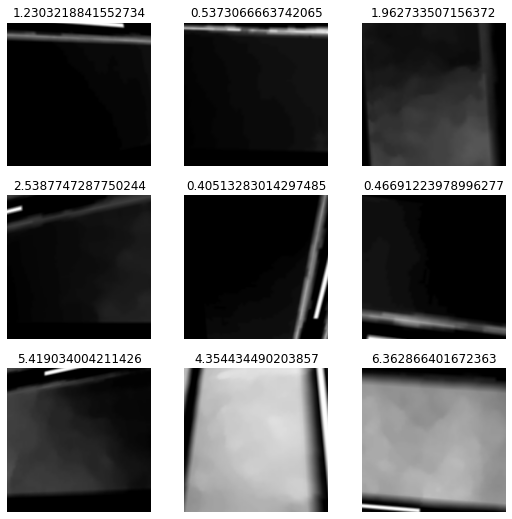

In [15]:
dls.show_batch()

In [16]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnet50Volumenv2Height')
]

In [17]:
from fastai.metrics import mae,rmse,mse

In [18]:
learn = cnn_learner(dls,resnet50,loss_func=MSELossFlat(), metrics=[mae,rmse,mse],cbs=callbacks).to_fp16()

In [19]:
# learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,20.515532,17.537756,3.994462,4.187810,17.537756,00:03


Better model found at epoch 0 with valid_loss value: 17.537755966186523.


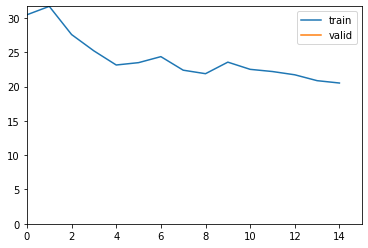

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,20.418756,19.321213,4.205021,4.395590,19.321213,00:03
1,19.390823,11.226913,3.119674,3.350659,11.226913,00:03
2,17.738079,9.298239,2.721735,3.049301,9.298239,00:03
3,17.469233,10.523976,2.966751,3.244068,10.523976,00:03
4,16.673922,11.856053,3.152236,3.443262,11.856053,00:03
5,16.298826,11.266400,2.963687,3.356546,11.266400,00:03
6,16.030819,11.503321,3.047491,3.391655,11.503321,00:03
7,15.592325,12.823591,3.298150,3.581004,12.823591,00:03
8,15.481091,9.885180,2.865570,3.144071,9.885180,00:03
9,15.244340,9.582315,2.791206,3.095531,9.582315,00:03


Better model found at epoch 0 with valid_loss value: 19.321212768554688.


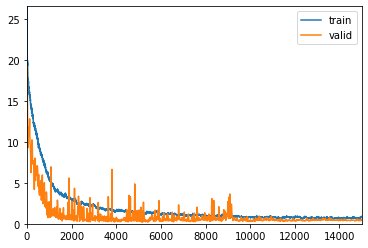

Better model found at epoch 1 with valid_loss value: 11.226913452148438.
Better model found at epoch 2 with valid_loss value: 9.298238754272461.
Better model found at epoch 10 with valid_loss value: 8.620890617370605.
Better model found at epoch 11 with valid_loss value: 6.2613677978515625.
Better model found at epoch 20 with valid_loss value: 5.5762434005737305.
Better model found at epoch 21 with valid_loss value: 4.190483093261719.
Better model found at epoch 35 with valid_loss value: 3.8207390308380127.
Better model found at epoch 36 with valid_loss value: 3.533571243286133.
Better model found at epoch 38 with valid_loss value: 3.5305609703063965.
Better model found at epoch 42 with valid_loss value: 2.8914830684661865.
Better model found at epoch 47 with valid_loss value: 2.4549942016601562.
Better model found at epoch 53 with valid_loss value: 2.1079678535461426.
Better model found at epoch 55 with valid_loss value: 2.048543930053711.
Better model found at epoch 56 with valid_los

In [20]:
learn.fine_tune(1000,base_lr=1e-3)

In [21]:
# learn.load('resnetrs50Masav2Height')

In [22]:
# df[df['image_id']=='datasetClean/br_2022-01-07T10-54-11.tif']

In [23]:
def is_test(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='test'

In [24]:
dbtest = DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_test),
                 get_y=get_volumen,
                 item_tfms = Resize(224),
                 batch_tfms=[*aug_transforms(size=224,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [25]:
dlstest = dbtest.dataloaders(path,bs=16)

In [26]:
learn.dls=dlstest

In [27]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5110525488853455.


(#4) [0.4115585684776306,0.5110525488853455,0.641528308391571,0.4115585684776306]

In [28]:
from sklearn.metrics import mean_absolute_error

In [29]:
preds,gt = learn.tta()

In [30]:
mean_absolute_error(gt,preds)

0.48896015